# Statistical model
1. Single LinReg
2. One LinReg per model
3. One LinReg per model but include operators in training data.

In [36]:
# Load data
from src.util import read_results
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from src.util import model_operators, train_and_score, train_test_validate_split, feature_transform_pipe, eval_result
import numpy as np
result_df = read_results(from_parquet=True)
result_df.head()
%load_ext autoreload
%autoreload 2


from src.util import all_cat_features
list_features = [x for x in result_df.columns if isinstance(result_df[x].iloc[0], np.ndarray)]
print(list_features)
result_df = result_df.drop(columns=list_features)
cat_features = list(set(result_df.columns).intersection(all_cat_features))
result_df[cat_features] = result_df[cat_features].astype(str)

train, test, validate = train_test_validate_split(result_df)
estimator_results = {}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['features', 'r_S', 'c_S', 'nnz_S', 'sparsity_S', 'morpheusfi_eis', 'morpheusfi_nis']
train set:
	Records: 189256
	Positive (speedup > 1 with factorizing)/Negative: 36554/152702 = 0.24 s
	Dataset types: ['synthetic']
\Compute Units: ['v100' '2080' 'CPU 16c' 'a40' 'CPU 08c' '1080' 'CPU 32c']
test set:
	Records: 81110
	Positive (speedup > 1 with factorizing)/Negative: 15420/65690 = 0.23 s
	Dataset types: ['synthetic']
\Compute Units: ['2080' 'CPU 08c' 'CPU 32c' 'a40' 'v100' 'CPU 16c' '1080']
validate set:
	Records: 42183
	Positive (speedup > 1 with factorizing)/Negative: 5569/36614 = 0.15 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


## Stat.1 Single LinReg


In [37]:
all_features = ['speedup', 'operator', 'num_cores', 'selectivity', 'cardinality_T',
       'cardinality_S', 'join', 'compute_unit', 'complexity_ratio',
       'times_mean', 'dataset_type', 'compute_type', 'label', 'features',
       'parallelism', 'mem_mat_read', 'mem_mat_write', 'mem_fac_read',
       'mem_fac_write', 'comp_scalar_mat', 'comp_lmm_mat', 'comp_rmm_mat',
       'comp_scalar_fac', 'comp_lmm_fac', 'comp_rmm_fac', 'comp_mat_col_major',
       'comp_fac_col_major', 'comp_scalar_dense', '13', '14',
       'comp_matrix_dense', 'mem_read_scalar_dense', 'mem_write_scalar_dense',
       'mem_read_matrix_dense', 'mem_write_matrix_dense', 'mem_read_rowsum',
       'mem_write_rowsum', 'mem_read_colsum', 'mem_write_colsum', '24', '25',
       'comp_rowsum', 'comp_colsum', 'comp_mat', 'comp_fac', 'comp_ratio',
       'tr', 'fr', 'r_S', 'c_S', 'TR', 'FR', 'nnz_T', 'nnz_S_sum', 'nnz_S',
       'r_T', 'c_T', 'sparsity_T', 'sparsity_S', 'morpheusfi_p',
       'morpheusfi_q', 'morpheusfi_eis', 'morpheusfi_ns', 'morpheusfi_nis',
       'gpu__architecture', 'gpu__number_of_sm', 'gpu__cores',
       'gpu_cache_size_l1', 'gpu_cache_size_l2', 'gpu_clock_speed_base',
       'gpu_clock_speed_max_boost', 'gpu_memory_bus_width', 'gpu_memory_size',
       'gpu_memory_clock', 'gpu_memory_bandwidth',
       'gpu_processing_power_half_precision',
       'gpu_processing_power_single_precision',
       'gpu_processing_power_double_precision', 'materialized_times_mean',
       'time_saved']
meta_features = ['dataset_type', 'features', 'comp_ratio', 'tr', 'fr', 'compute_unit', 'materialized_times_mean']
dep = ['speedup', 'times_mean', 'label', 'time_saved','materialized_times_mean']
indep = list(set(all_features).intersection(result_df.columns) - set(dep) - set(meta_features))

In [38]:
X_train, y_train = train[indep], train["time_saved"]
X_test, y_test = test[indep], test["time_saved"]
X_validate, y_validate = validate[indep], validate["time_saved"]

2024-03-19 20:26:33.652 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'compute_type', 'gpu__architecture', 'join']


2024-03-19 20:26:38.886 | INFO     | src.util:eval_model:383 - Model <class 'sklearn.pipeline.Pipeline'>, linearregression
 test cols: Index(['mem_write_matrix_dense', 'gpu_memory_size', 'comp_rmm_mat',
       'gpu__cores', 'morpheusfi_ns', 'comp_scalar_fac', 'comp_rmm_fac',
       'compute_type', 'mem_read_colsum', 'gpu_clock_speed_max_boost',
       'mem_read_scalar_dense', 'mem_fac_write', 'mem_read_matrix_dense', 'TR',
       'gpu_clock_speed_base', 'operator', 'mem_mat_write', '24', 'nnz_S_sum',
       'mem_read_rowsum', 'num_cores', 'selectivity', 'gpu__number_of_sm',
       'gpu_processing_power_half_precision', 'mem_write_scalar_dense',
       'parallelism', 'comp_scalar_mat', 'comp_mat_col_major', 'cardinality_T',
       'gpu_memory_bus_width', '14', 'comp_lmm_fac', 'c_T', 'mem_fac_read',
       'comp_colsum', 'gpu_memory_bandwidth',
       'gpu_processing_power_double_precision', 'complexity_ratio',
       'morpheusfi_p', 'join', 'comp_mat',
       'gpu_processing_power_singl

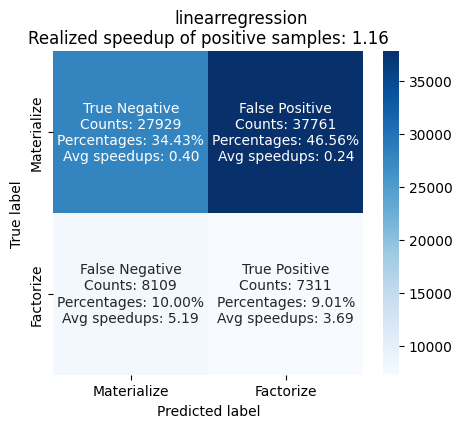

In [39]:
lin_reg_combined = train_and_score(LinearRegression(), X_train, X_test, y_train, y_test, full_dataset=test, fillna=True)

y_pred = pd.Series(lin_reg_combined.predict(X_test), index=X_test.index)
resul = eval_result(y_test, y_pred, full_dataset=test, model_name='STAT.1')

estimator_results['STAT.1'] = resul[0]

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

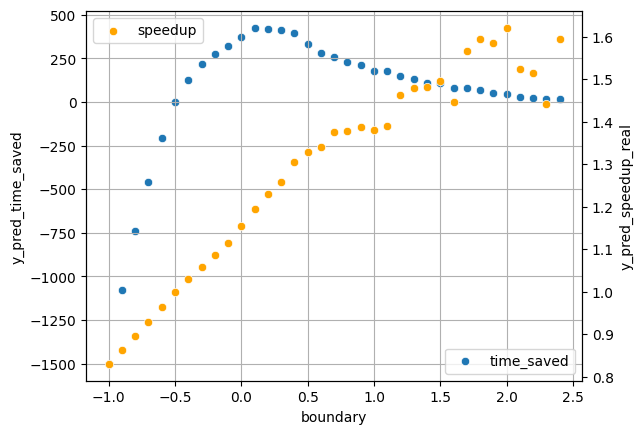

In [40]:
from src.util import eval_result

def plot_boundary(y_true, y_pred, lower=-1., upper=1., step=0.1):
    # Create a list to store the results
    results = []

    # Loop over the range of boundaries
    x= np.arange(lower, upper, step)
    for boundary in x:
        result = eval_result(y_true, y_pred = y_pred > boundary, full_dataset=test)
        results.append({'boundary': boundary, **result[2]})

    dd = pd.DataFrame(results)
    ax=sns.scatterplot(data=dd, x="boundary", y="y_pred_time_saved", label='time_saved')
    sns.scatterplot(data=dd, x="boundary", y="y_pred_speedup_real", ax=ax.twinx(), label='speedup', color='orange')
    ax.grid()
    ax.legend(loc='lower right')
    return ax
plot_boundary(y_test, pd.Series(lin_reg_combined.predict(X_test), index=X_test.index), upper=2.5)

## STAT.2 Single linreg on only Models

2024-03-19 20:26:46.504 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'compute_type', 'gpu__architecture', 'join']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-19 20:26:47.734 | INFO     | src.util:eval_model:383 - Model <class 'sklearn.pipeline.Pipeline'>, linearregression
 test cols: Index(['mem_write_matrix_dense', 'gpu_memory_size', 'comp_rmm_mat',
       'gpu__cores', 'morpheusfi_ns', 'comp_scalar_fac', 'comp_rmm_fac',
       'compute_type', 'mem_read_colsum', 'gpu_clock_speed_max_boost',
       'mem_read_scalar_dense', 'mem_fac_write', 'mem_read_matrix_dense', 'TR',
       'gpu_clock_speed_base', 'operator', 'mem_mat_write', '24', 'nnz_S_sum',
       'mem_read_rowsum', 'num_cores', 'selectivity', 'gpu__number_of_sm',
       'gpu_processing_power_half_precision', 'mem_write_scalar_dense',
       'parallelism', 'comp_scalar_mat', 'comp_mat_col_major', 'cardinality_T',
       'gpu_memory_bus_width', '14', 'comp_lmm_fac', 'c_T', 'mem_fac_read',
       'comp_colsum', 'gpu_memory_bandwidth',
       'gpu_processing_power_double_precision', 'complexity_ratio',
       'morpheusfi_p', 'join', 'comp_mat',
       'gpu_processing_power_singl

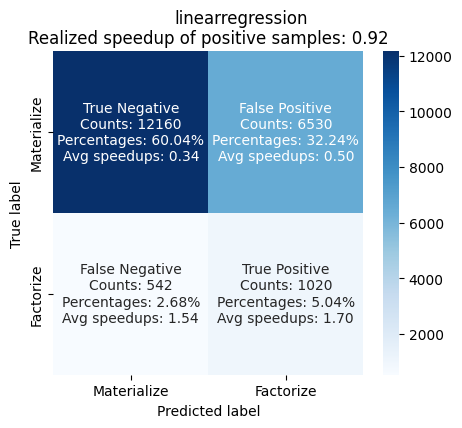

In [41]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train["time_saved"]
X_test, y_test = test[indep], test["time_saved"]
X_validate, y_validate = validate[indep], validate["time_saved"]
lin_reg_model = train_and_score(LinearRegression(), X_train, X_test, y_train, y_test, full_dataset=test, fillna=True)

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

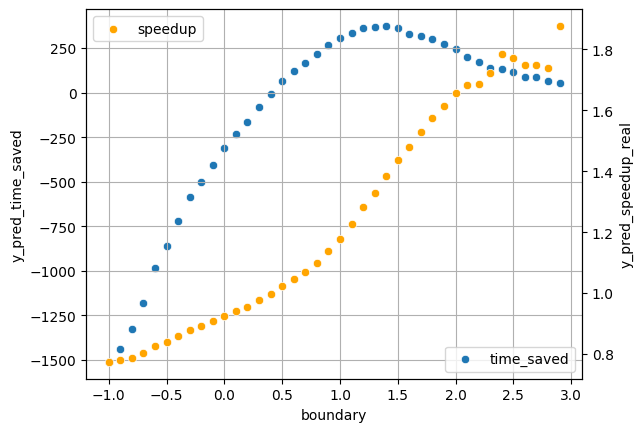

In [42]:
y_pred = pd.Series(lin_reg_model.predict(X_test), index=X_test.index)
plot_boundary(y_test, y_pred, upper=3.0)

In [43]:
estimator_results['STAT.2'] = eval_result(y_test, y_pred>1.5, full_dataset=test, model_name='STAT.2')[0]

## STAT.3 Linear Regression predict runtime for F & M
Two regression, predict runtime for both F and M. Select lowest

In [44]:
from src.analytical_model import create_linreg_ensemble, predict_linreg_ensemble


train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
# Add a constant column to the dataframes
train['constant'] = 1
test['constant'] = 1
validate['constant'] = 1

X_train, y_train = train[indep], train[["times_mean", "materialized_times_mean"]]
X_test, y_test = test[indep], test[["times_mean", "materialized_times_mean"]]
X_validate, y_validate = validate[indep], validate[["times_mean", "materialized_times_mean"]]

train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


In [45]:
linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by='constant',
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, y_test.columns, split_by='constant')

2024-03-19 20:26:50.394 | INFO     | src.analytical_model:create_linreg_ensemble:99 - Creating a linear regression ensemble for the analytical model, splitting by constant
2024-03-19 20:26:50.408 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'compute_type', 'gpu__architecture', 'join']


2024-03-19 20:26:51.678 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'compute_type', 'gpu__architecture', 'join']
2024-03-19 20:26:53.031 | INFO     | src.analytical_model:create_linreg_ensemble:125 - Created a linear regression ensemble for the analytical model with 2 models
2024-03-19 20:26:53.033 | INFO     | src.analytical_model:predict_linreg_ensemble:68 - Predicting results of the analytical model using a linear regression ensemble


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

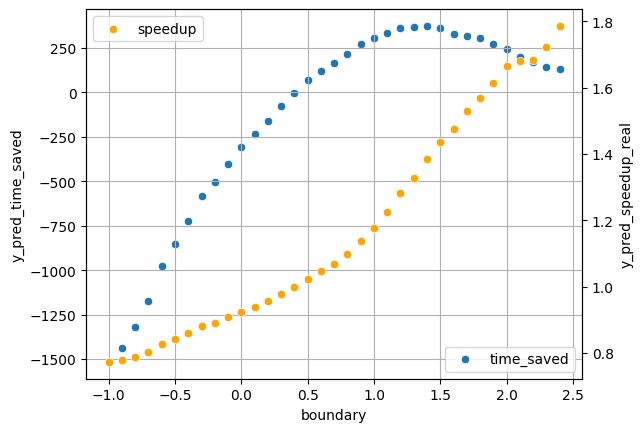

In [46]:
y_pred = (pred.materialized_times_mean - pred.times_mean)
plot_boundary((y_test.materialized_times_mean - y_test.times_mean), y_pred, upper=2.5)

In [47]:
res = eval_result((y_test.materialized_times_mean - y_test.times_mean), y_pred = y_pred > 1.4, full_dataset=test)
estimator_results['STAT.3'] = res[0]

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]


## Stat.4 Separate regressors for each model type

## Stat.4 Separate regressors for each model type

In [48]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train["time_saved"]
X_test, y_test = test[indep], test["time_saved"]
X_validate, y_validate = validate[indep], validate["time_saved"]

linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by='operator',
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, [y_test.name], split_by='operator')

2024-03-19 20:26:56.382 | INFO     | src.analytical_model:create_linreg_ensemble:99 - Creating a linear regression ensemble for the analytical model, splitting by operator
2024-03-19 20:26:56.394 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'compute_type', 'gpu__architecture', 'join']
2024-03-19 20:26:56.545 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'compute_type', 'gpu__architecture', 'join']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-19 20:26:56.717 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'compute_type', 'gpu__architecture', 'join']
2024-03-19 20:26:56.879 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'compute_type', 'gpu__architecture', 'join']
2024-03-19 20:26:57.037 | INFO     | src.analytical_model:create_linreg_ensemble:125 - Created a linear regression ensemble for the analytical model with 4 models
2024-03-19 20:26:57.039 | INFO     | src.analytical_model:predict_linreg_ensemble:68 - Predicting results of the analytical model using a linear regression ensemble


In [49]:
res = eval_result(y_test, y_pred = pred.time_saved, full_dataset=test)
estimator_results['STAT.4'] = res[0]

2024-03-19 20:26:57.307 | INFO     | src.util:eval_result:427 - Assuming y_pred is 'time_saved', converting to bool


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]


## Stat. 5 split CPU and GPU

In [50]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train["time_saved"]
X_test, y_test = test[indep], test["time_saved"]
X_validate, y_validate = validate[indep], validate["time_saved"]

split_by = 'compute_type'
linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by=split_by,
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, [y_test.name], split_by=split_by)

2024-03-19 20:26:57.594 | INFO     | src.analytical_model:create_linreg_ensemble:99 - Creating a linear regression ensemble for the analytical model, splitting by compute_type
2024-03-19 20:26:57.606 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'compute_type', 'gpu__architecture', 'join']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-19 20:26:57.869 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'compute_type', 'gpu__architecture', 'join']
2024-03-19 20:26:58.238 | INFO     | src.analytical_model:create_linreg_ensemble:125 - Created a linear regression ensemble for the analytical model with 2 models
2024-03-19 20:26:58.239 | INFO     | src.analytical_model:predict_linreg_ensemble:68 - Predicting results of the analytical model using a linear regression ensemble


/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

<Axes: xlabel='boundary', ylabel='y_pred_time_saved'>

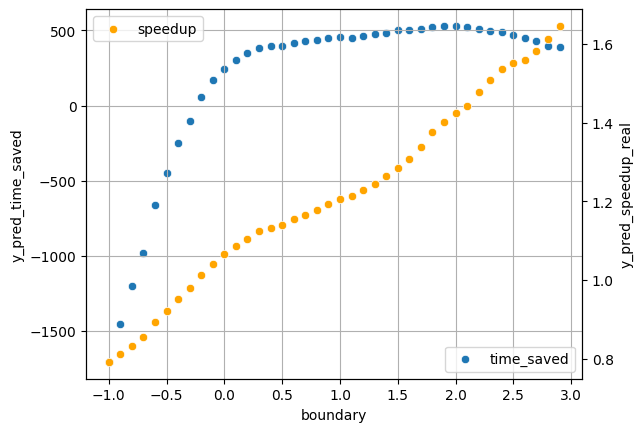

In [51]:
res = eval_result(y_test, y_pred = pred.time_saved > 0.7, full_dataset=test)
estimator_results['STAT.5'] = res[0]
res[0]
plot_boundary(y_test, pred.time_saved, upper=3.0)

## Stat.6 Split by F,M,operator

In [52]:
train, test, validate = train_test_validate_split(result_df[result_df.operator.isin(model_operators)])
X_train, y_train = train[indep], train[["times_mean", "materialized_times_mean"]]
X_test, y_test = test[indep], test[["times_mean", "materialized_times_mean"]]
X_validate, y_validate = validate[indep], validate[["times_mean", "materialized_times_mean"]]

split_by = ['operator']
linreg_f_m = create_linreg_ensemble(
    train,
    X_train,
    y_train,
    clf_func=feature_transform_pipe,
    clf_kwargs=dict(model=LinearRegression, X_train=X_train, fillna=True),
    rfecv=False,
    split_by=split_by,
)
pred = predict_linreg_ensemble(linreg_f_m, test, X_test, y_test.columns, split_by=split_by)

2024-03-19 20:27:01.910 | INFO     | src.analytical_model:create_linreg_ensemble:99 - Creating a linear regression ensemble for the analytical model, splitting by ['operator']
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/analytical_model.py:101: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (split_value_tuple), group_df in df.groupby(split_by):
2024-03-19 20:27:01.925 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'compute_type', 'gpu__architecture', 'join']


train set:
	Records: 47254
	Positive (speedup > 1 with factorizing)/Negative: 3715/43539 = 0.09 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 16c' '1080' 'v100' 'CPU 32c' 'a40' '2080']
test set:
	Records: 20252
	Positive (speedup > 1 with factorizing)/Negative: 1562/18690 = 0.08 s
	Dataset types: ['synthetic']
\Compute Units: ['CPU 08c' 'CPU 32c' 'CPU 16c' '1080' 'a40' '2080' 'v100']
validate set:
	Records: 11187
	Positive (speedup > 1 with factorizing)/Negative: 1123/10064 = 0.11 s
	Dataset types: ['synthetic' 'hamlet' 'tpc_ai']
\Compute Units: ['p100' 'CPU 32c' 'CPU 16c' 'CPU 08c' '2080' '1080' 'v100' 'a40']


2024-03-19 20:27:02.107 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'compute_type', 'gpu__architecture', 'join']
2024-03-19 20:27:02.286 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'compute_type', 'gpu__architecture', 'join']
2024-03-19 20:27:02.465 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'compute_type', 'gpu__architecture', 'join']
2024-03-19 20:27:02.655 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'compute_type', 'gpu__architecture', 'join']
2024-03-19 20:27:02.829 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'compute_type', 'gpu__architecture', 'join']
2024-03-19 20:27:03.007 | INFO     | src.util:feature_transform_pipe:357 - categorical_features=['operator', 'compute_type', 'gpu__architecture', 'join']
2024-03-19 20:27:03.173 | INFO     | src.util:feature_transform_pipe:357 - c

/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Documents/uni/y5/thesis/amalur/amalur-experiments/results/full_1/src/util.py:401: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[index_selector]
/home/pepijn/Do

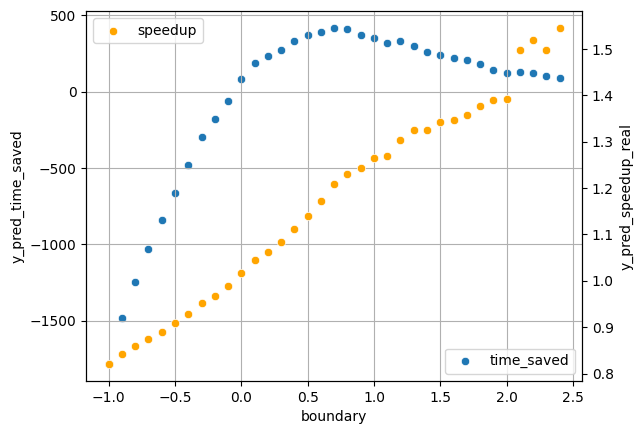

In [53]:
y_pred = (pred.materialized_times_mean - pred.times_mean)
plot_boundary((y_test.materialized_times_mean - y_test.times_mean), y_pred, upper=2.5)
res = eval_result((y_test.materialized_times_mean - y_test.times_mean), y_pred = y_pred > 0.6, full_dataset=test)
estimator_results['STAT.6'] = res[0]

# Analysis

In [56]:
pd.DataFrame(estimator_results.values())

,accuracy,precision,recall,f1,speedup
0,0.434472,0.162207,0.474125,0.241718,"{'y_true_mat_time': 5403.0834004424105, 'y_tru..."
1,0.917539,0.443750,0.272727,0.337827,"{'y_true_mat_time': 4733.428332464589, 'y_true..."
2,0.870235,0.071543,0.056978,0.063435,"{'y_true_mat_time': 4733.428332464589, 'y_true..."
3,0.688080,0.075219,0.269526,0.117614,"{'y_true_mat_time': 4733.428332464589, 'y_true..."
4,0.850780,0.080460,0.089629,0.084797,"{'y_true_mat_time': 4733.428332464589, 'y_true..."
5,0.854138,0.078182,0.082586,0.080324,"{'y_true_mat_time': 4733.428332464589, 'y_true..."
